In [47]:
import os
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Set variables
numcycles = 10
imperwell = 1025
row_widths = [5,11,17,19,23,25,27,29,29,31,33,33,33,35,35,35,37,37,37,37,37,35,35,35,33,33,33,31,29,29,27,25,23,19,17,11,5]

In [49]:
def merge_csvs(csvfolder, filename, column_list=None, filter_string=None):
    df_dict={}
    count = 0
    folderlist = os.listdir(csvfolder)
    if filter_string:
        folderlist = [x for x in folderlist if filter_string in x]
    print(count, datetime.datetime.ctime(datetime.datetime.now()))
    for eachfolder in folderlist:
            if os.path.isfile(os.path.join(csvfolder, eachfolder, filename)):
                if not column_list:
                    df_dict[eachfolder]=pd.read_csv(os.path.join(csvfolder, eachfolder, filename),index_col=False)
                else:
                    df_dict[eachfolder]=pd.read_csv(os.path.join(csvfolder, eachfolder, filename),index_col=False,usecols=column_list)
                count+=1
                if count % 500 == 0:
                    print(count, datetime.datetime.ctime(datetime.datetime.now()))
    print(count, datetime.datetime.ctime(datetime.datetime.now()))
    df_merged = pd.concat(df_dict, ignore_index=True)
    print('done concatenating at', datetime.datetime.ctime(datetime.datetime.now()))
    
    return df_merged

In [50]:
max_width = max(row_widths)
pos_dict = {}
count = 0
# creates dict of (xpos,ypos) = imnumber
for row in range(len(row_widths)):
    row_width = row_widths[row]
    left_pos = int((max_width-row_width)/2)
    for col in range(row_width):
        if row%2 == 0:
            pos_dict[(int(left_pos + col), row)] = count
            count += 1
        else:
            right_pos = left_pos + row_width - 1
            pos_dict[(int(right_pos - col), row)] = count
            count += 1
# make dict into df
pos_df = pd.DataFrame.from_dict(pos_dict, orient = "index").reset_index().rename(columns={"index": "loc", 0: "Metadata_Site"})
pos_df[['x_loc', 'y_loc']] = pd.DataFrame(pos_df['loc'].tolist(), index=pos_df.index) 

# Check Alignment - Plate45

In [ ]:
csvfolder = "/LOCATION/images_aligned/barcoding"

shift_list = []
corr_list = []
for cycle in range(1,numcycles+1):
    if cycle != 1:
        shift_list.append(f'Align_Xshift_Cycle{cycle:02d}_DAPI')
        shift_list.append(f'Align_Yshift_Cycle{cycle:02d}_DAPI')
    for cycle2 in range(cycle+1,numcycles+1):
        corr_list.append(f'Correlation_Correlation_Cycle{cycle:02d}_DAPI_Cycle{cycle2:02d}_DAPI')
id_list = ['Metadata_Well','Metadata_Plate','Metadata_Site']
column_list = id_list+shift_list+corr_list

df_image = merge_csvs(csvfolder, 'BarcodingApplication_Image.csv', column_list,filter_string='Plate45')

0 Fri Sep 13 13:15:46 2024
500 Fri Sep 13 13:15:50 2024
1000 Fri Sep 13 13:15:53 2024
1500 Fri Sep 13 13:15:56 2024
2000 Fri Sep 13 13:15:59 2024
2500 Fri Sep 13 13:16:02 2024
3000 Fri Sep 13 13:16:05 2024
3500 Fri Sep 13 13:16:08 2024
4000 Fri Sep 13 13:16:11 2024
4500 Fri Sep 13 13:16:14 2024
5000 Fri Sep 13 13:16:17 2024
5125 Fri Sep 13 13:16:17 2024
done concatenating at Fri Sep 13 13:16:18 2024


In [52]:
df_shift = df_image[shift_list+id_list]
df_shift = pd.melt(df_shift, id_vars=id_list)
df_corr = df_image[corr_list+id_list]
df_corr = pd.melt(df_corr, id_vars=id_list)
df_corr_crop = df_image[[x for x in corr_list if 'Correlation_Cycle01' in x]+id_list]
df_corr_crop = pd.melt(df_corr_crop, id_vars=id_list)

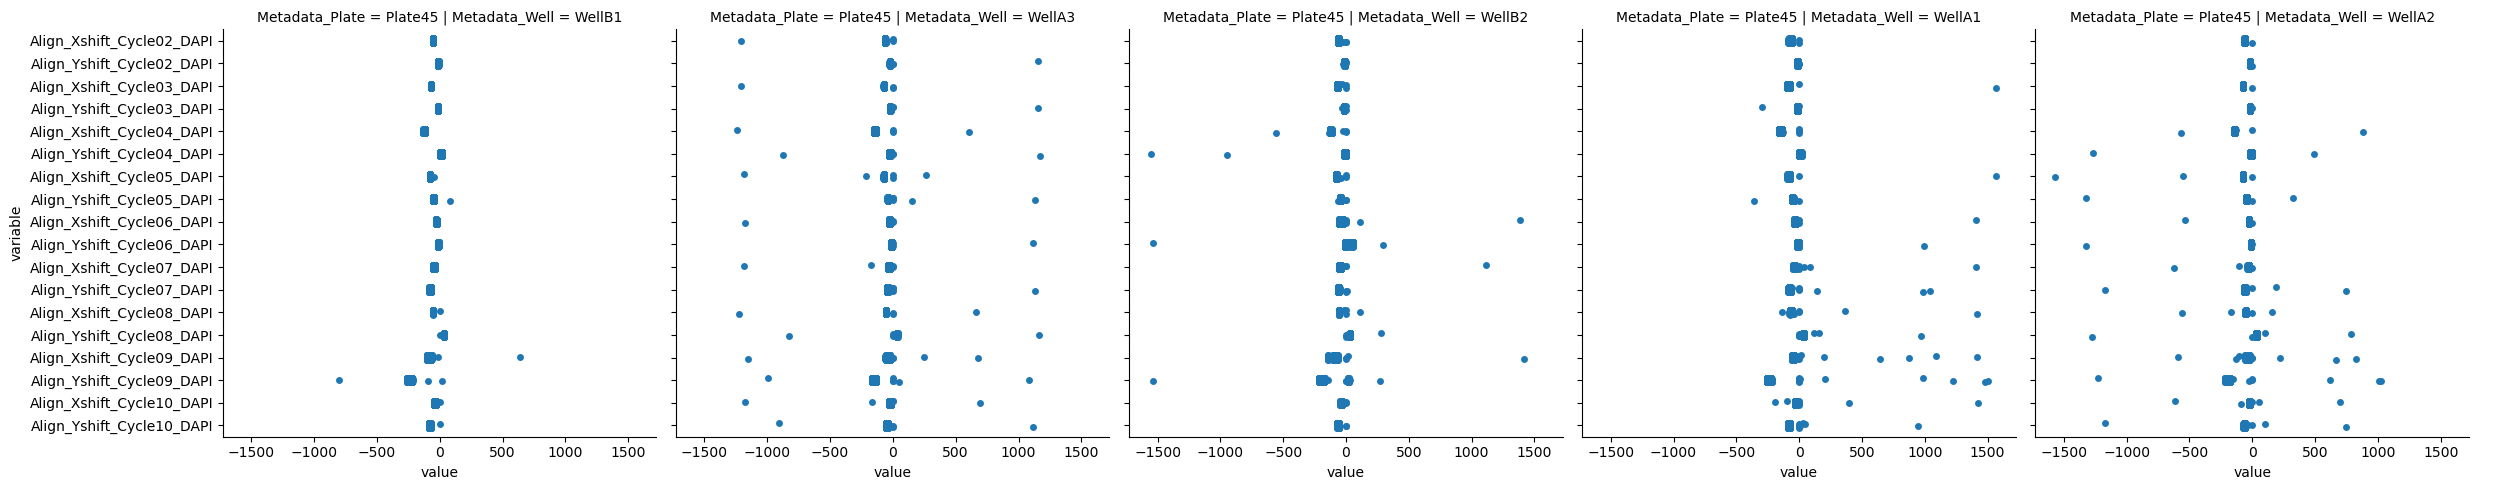

In [53]:
# Pixels shifted to align each cycle to Cycle01
sns.catplot(data=df_shift, x="value",y="variable",orient="h", 
            col='Metadata_Well', row='Metadata_Plate')

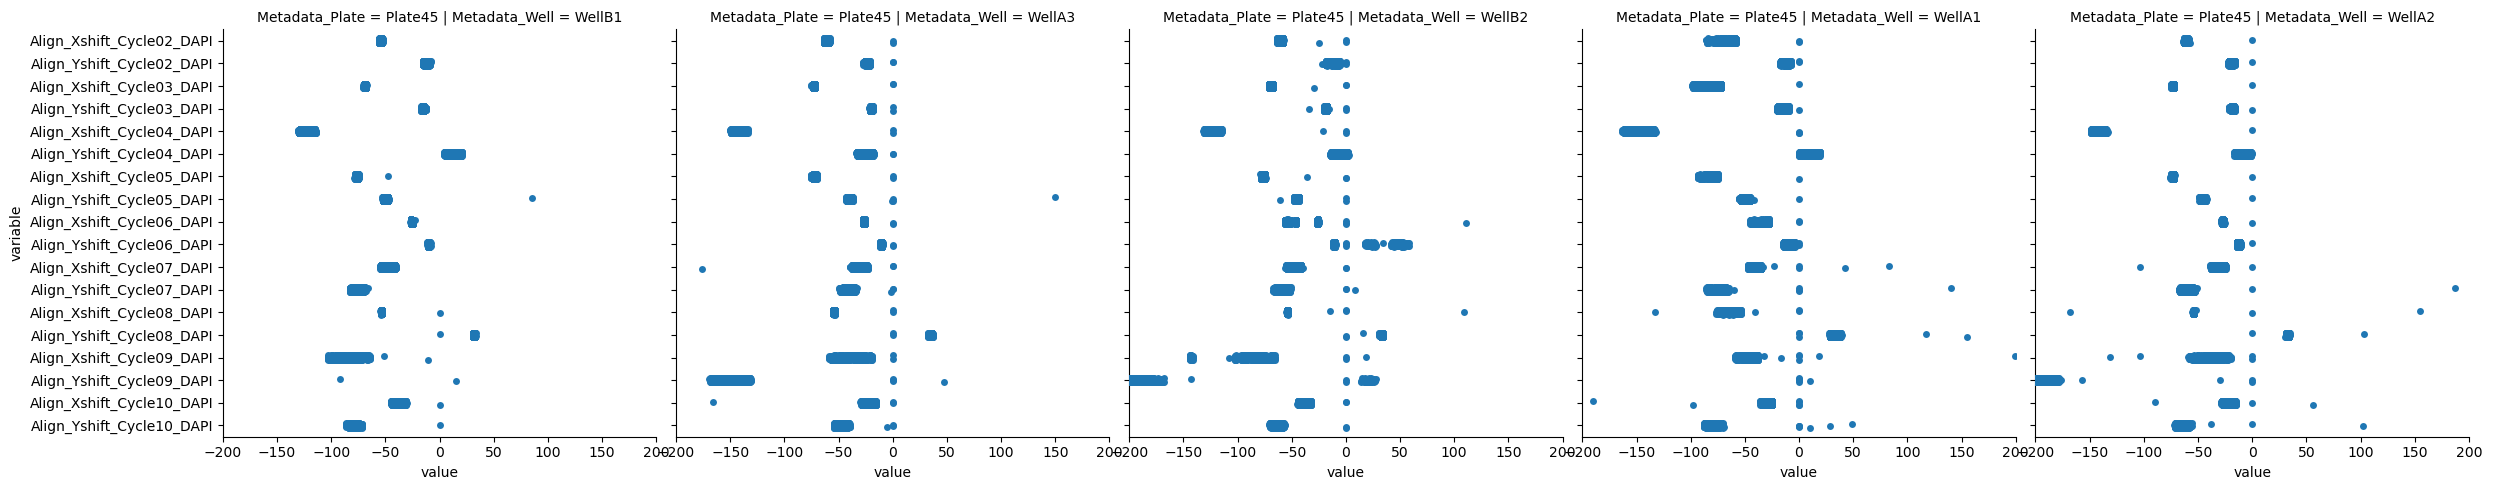

In [54]:
# Pixels shifted to align each cycle to Cycle01 - x axis limits
g = sns.catplot(data=df_shift, x="value",y="variable",orient="h", 
            col='Metadata_Well', row='Metadata_Plate')
g.set(xlim=(-200,200))

In [55]:
value = 50
temp = df_shift.loc[df_shift['value']>value].groupby(['Metadata_Plate','Metadata_Well','Metadata_Site']).count().reset_index()
for well in temp['Metadata_Well'].unique():
    print(f"{well} has {len(temp.loc[temp['Metadata_Well']==well])} site with shift more than {value} (out of {imperwell})")

WellA1 has 7 site with shift more than 50 (out of 1025)
WellA2 has 6 site with shift more than 50 (out of 1025)
WellA3 has 3 site with shift more than 50 (out of 1025)
WellB1 has 2 site with shift more than 50 (out of 1025)
WellB2 has 87 site with shift more than 50 (out of 1025)


{}


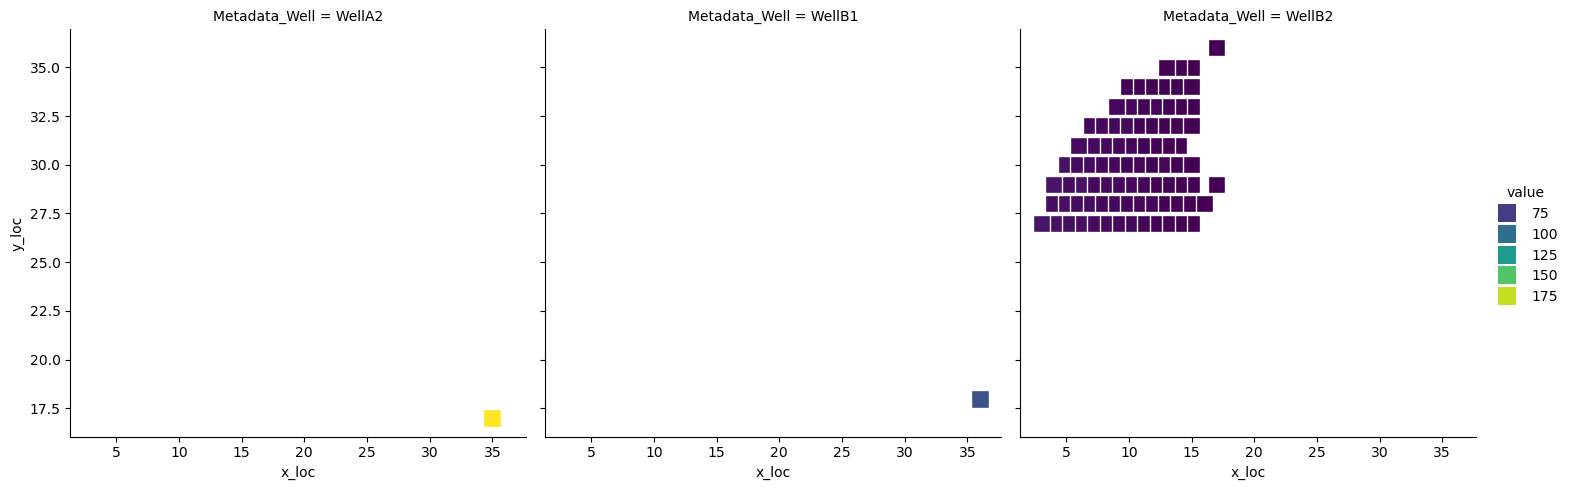

In [56]:
# plot size of shift by location, ignoring shifts >200
temp = df_shift.loc[df_shift['value']>value].groupby(['Metadata_Plate','Metadata_Well','Metadata_Site']).max().reset_index().merge(pos_df)
temp = temp.loc[temp['value']<200]
g = sns.relplot(
    data=temp,
    x="x_loc", y="y_loc", hue="value", #hue_norm=(0,200),
    col='Metadata_Well', col_wrap = 3,
    palette='viridis', marker='s', s=150,
    )
print(g._legend_data)
display(g)

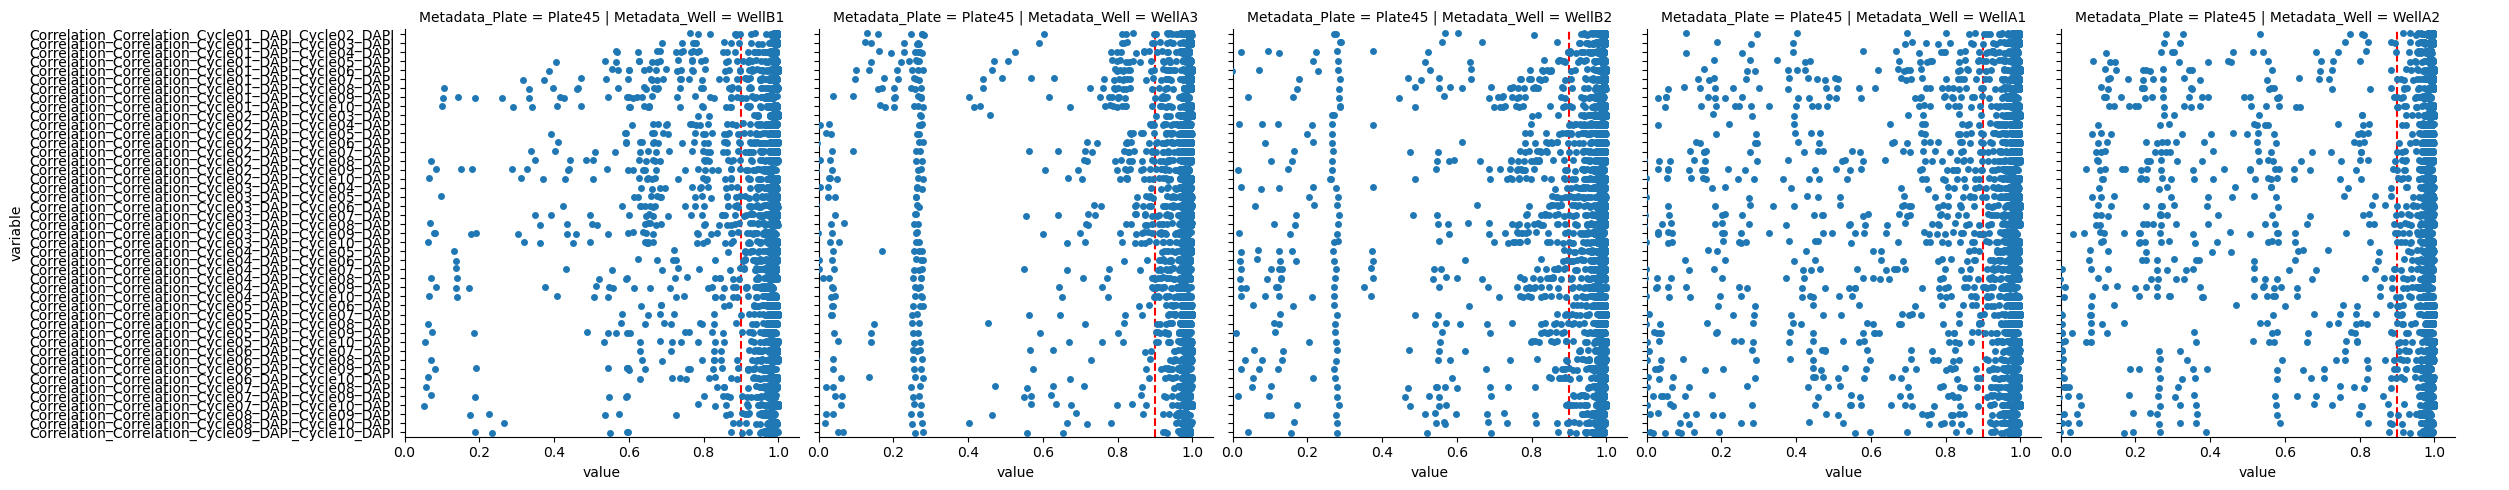

In [57]:
# DAPI correlations after alignment (using "Correlation")
# Need all points to be better than red line
g = sns.catplot(data=df_corr, x="value",y="variable",orient="h", 
                col='Metadata_Well', row='Metadata_Plate')
g.refline(x = .9, color='red') 
g.set(xlim=(0, None))

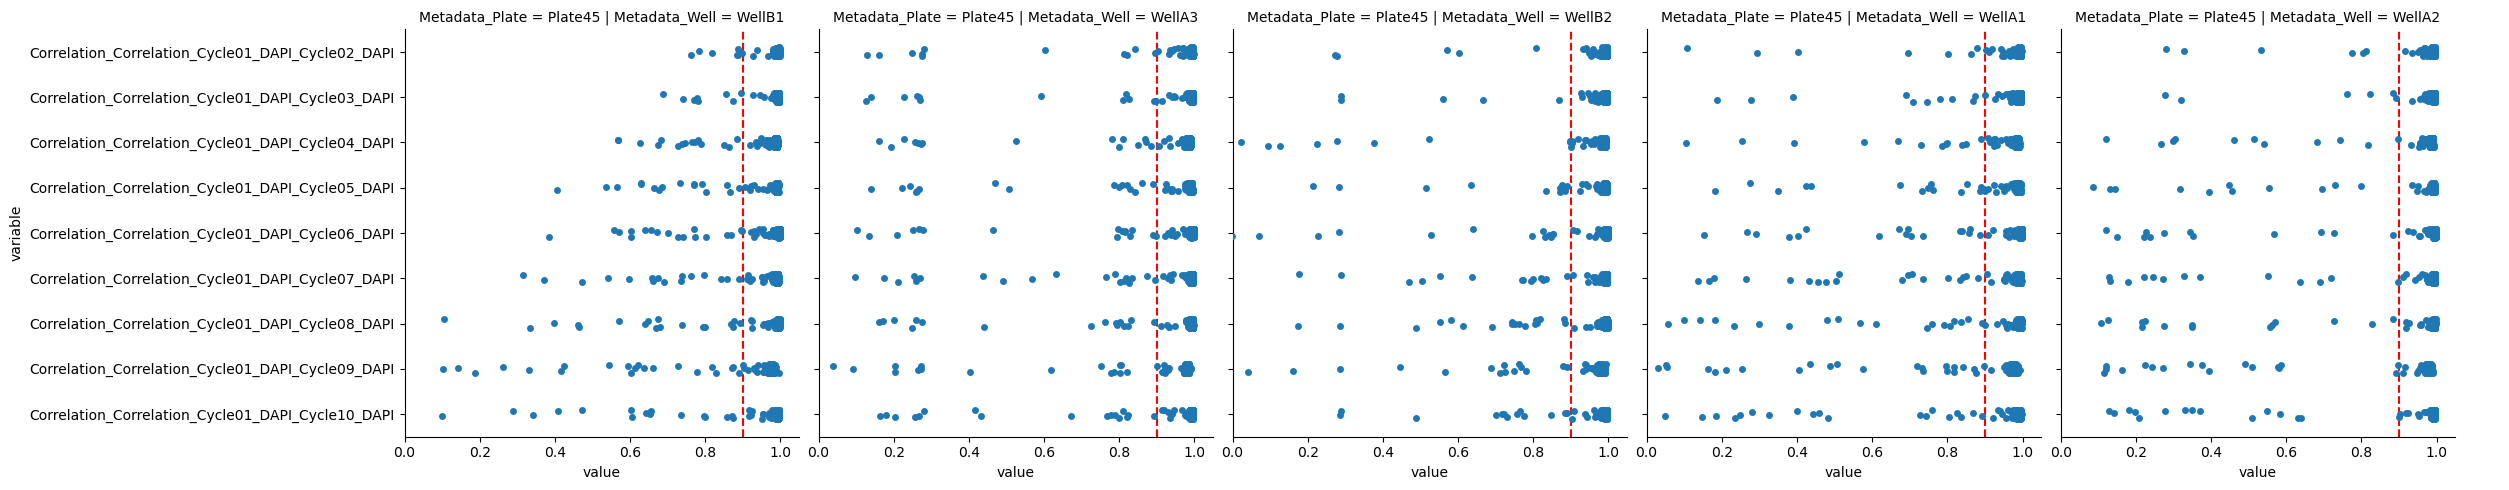

In [58]:
# DAPI correlations after alignment (using "Correlation") - only correlations to Cycle01
# Need all points to be better than red line
g = sns.catplot(data=df_corr_crop, x="value",y="variable",orient="h", 
                col='Metadata_Well', row='Metadata_Plate')
g.refline(x = .9, color='red') 
g.set(xlim=(0, None))

In [59]:
print('For correlations to Cycle01')
print(f"{len(df_corr_crop.groupby(['Metadata_Plate','Metadata_Well','Metadata_Site']))} total sites")
print(f"{len(df_corr_crop.loc[df_corr_crop['value']<.9])} sites with correlation <.9")
print(f"{len(df_corr_crop.loc[df_corr_crop['value']<.8])} sites with correlation <.8")
# Print Awful alignment scores after alignment
df_corr_crop.sort_values(by='value').head(20)

For correlations to Cycle01
5125 total sites
624 sites with correlation <.9
455 sites with correlation <.8


,Metadata_Well,Metadata_Plate,Metadata_Site,variable,value
22573,WellB2,Plate45,1015,Correlation_Correlation_Cycle01_DAPI_Cycle06_DAPI,-0.002223
13549,WellB2,Plate45,803,Correlation_Correlation_Cycle01_DAPI_Cycle04_DAPI,0.021365
37630,WellA1,Plate45,1016,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.029884
36120,WellA3,Plate45,1013,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.038533
37948,WellB2,Plate45,1015,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.041820
43542,WellA1,Plate45,529,Correlation_Correlation_Cycle01_DAPI_Cycle10_DAPI,0.048807
38417,WellA1,Plate45,529,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.051372
39891,WellA1,Plate45,458,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.052825
33292,WellA1,Plate45,529,Correlation_Correlation_Cycle01_DAPI_Cycle08_DAPI,0.057103
24904,WellB2,Plate45,1016,Correlation_Correlation_Cycle01_DAPI_Cycle06_DAPI,0.070251


In [60]:
# Print mediocre alignment score after alignment
df_corr_crop.loc[df_corr_crop['value']<.5].sort_values(by='value', ascending=False).head(20)

,Metadata_Well,Metadata_Plate,Metadata_Site,variable,value
25870,WellA3,Plate45,1013,Correlation_Correlation_Cycle01_DAPI_Cycle07_DAPI,0.491602
38400,WellA2,Plate45,383,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.489780
36379,WellA1,Plate45,532,Correlation_Correlation_Cycle01_DAPI_Cycle09_DAPI,0.488359
33306,WellB2,Plate45,531,Correlation_Correlation_Cycle01_DAPI_Cycle08_DAPI,0.487691
43556,WellB2,Plate45,531,Correlation_Correlation_Cycle01_DAPI_Cycle10_DAPI,0.487447
41504,WellA1,Plate45,532,Correlation_Correlation_Cycle01_DAPI_Cycle10_DAPI,0.481421
32122,WellA1,Plate45,455,Correlation_Correlation_Cycle01_DAPI_Cycle08_DAPI,0.480124
28462,WellA1,Plate45,368,Correlation_Correlation_Cycle01_DAPI_Cycle07_DAPI,0.478109
29273,WellB1,Plate45,455,Correlation_Correlation_Cycle01_DAPI_Cycle07_DAPI,0.472938
44648,WellB1,Plate45,455,Correlation_Correlation_Cycle01_DAPI_Cycle10_DAPI,0.472747


In [61]:
# Print huge pixel shifts
print(f"{len(df_shift.loc[df_shift['value']>100])} images shifted with huge pixel shifts")

df_shift.loc[df_shift['value']>100].sort_values(by='value', ascending=False).head(20)

68 images shifted with huge pixel shifts


,Metadata_Well,Metadata_Plate,Metadata_Site,variable,value
34604,WellA1,Plate45,1022,Align_Xshift_Cycle05_DAPI,1567
14104,WellA1,Plate45,1022,Align_Xshift_Cycle03_DAPI,1566
80891,WellA1,Plate45,458,Align_Yshift_Cycle09_DAPI,1501
78630,WellA1,Plate45,1016,Align_Yshift_Cycle09_DAPI,1478
86266,WellA1,Plate45,457,Align_Xshift_Cycle10_DAPI,1423
73823,WellB2,Plate45,1015,Align_Xshift_Cycle09_DAPI,1416
65766,WellA1,Plate45,457,Align_Xshift_Cycle08_DAPI,1415
76016,WellA1,Plate45,457,Align_Xshift_Cycle09_DAPI,1413
55516,WellA1,Plate45,457,Align_Xshift_Cycle07_DAPI,1409
45266,WellA1,Plate45,457,Align_Xshift_Cycle06_DAPI,1405
